In [1]:
import pandas as pd
import os

def load_file(path, file):
    df = pd.read_csv(path + file,
                 parse_dates={'date_time' : ['tstp']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='date_time')
    df.columns = ['id', 'electricity']
    df['electricity'] = df['electricity'].convert_objects(convert_numeric=True)
    df = df.groupby('id').resample('h').sum()
    return df

def load_series(data_path, file, params):
    df = pd.read_csv(data_path + file,
                 parse_dates={'date' : [params['column_sort']]}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col=['date'])
    return df

def create_x_tensors(data, n_in, dropNaN=True):
    """
    Creates X tensors for LSTM time series prediction
    Output has shape (samples, timesteps, features)
    """
    # create lagged variables
    cols = list()
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
    lagged_df = pd.concat(cols, axis=1)
    if dropNaN:
        lagged_df.dropna(inplace=True)

    # reshape data to shape [samples, timesteps, features]
    return lagged_df.values.reshape((lagged_df.shape[0], n_in, n_features))


def create_y_tensor(data, n_out=1, dropNaN=True):
    """
    Creates Y tensor for LSTM time series prediction
    """
    dff = pd.DataFrame(data)
    cols = list()
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
    lagged_df = pd.concat(cols, axis=1)
    if dropNaN:
        lagged_df.dropna(inplace=True)

    # reshape data to shape [samples, timesteps]
    return lagged_df.values.reshape((lagged_df.shape[0], n_out))

def prepare_data(data, n_in, n_out, step_foreward):
    df = pd.DataFrame(data)

    # check steps and cut data at the beginning
    timesteps = df.shape[0]
    steps = int((timesteps - n_in - n_out) / step_foreward)
    nDrop = timesteps - (steps * n_out + n_in + n_out)
    if nDrop > 0:
        df = df[nDrop:]
    return df

def create_tensors(data, column_value, n_in=1, n_out=1, step_foreward=1, dropNaN=True):
    n_features = data.shape[1]
    df = pd.DataFrame(data)

    # X tensor
    cols = list()
    dfX = df[column_value][:-n_out]
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
    lagged_df = pd.concat(cols, axis=1)
    if dropNaN:
        lagged_df.dropna(inplace=True)
    # reshape data to shape [samples, timesteps, features]
    tensor_X = lagged_df.values.reshape((lagged_df.shape[0], n_in, n_features))
    tensor_X = tensor_X[range(0, tensor_X.shape[0], step_foreward)]

    # y tensor
    cols = list()
    dfY = df[column_value][n_in:]
    for i in range(0, n_out):
        cols.append(dfY.shift(-i))
    lagged_df = pd.concat(cols, axis=1)
    if dropNaN:
        lagged_df.dropna(inplace=True)
    # reshape data to shape [samples, timesteps]
    tensor_y = lagged_df.values.reshape((lagged_df.shape[0], n_out))
    tensor_y = tensor_y[range(0, tensor_y.shape[0], step_foreward)]

    return tensor_X, tensor_y

In [2]:
%matplotlib inline
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt

%matplotlib inline
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
rcParams['figure.figsize'] = 20, 6
set_matplotlib_formats('retina')

import warnings; 
warnings.simplefilter('ignore')

from datetime import datetime
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

import keras
import itertools
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.utils import to_categorical
from keras.constraints import maxnorm
from keras.optimizers import Adam 
from keras.callbacks import History, TerminateOnNaN, ReduceLROnPlateau, EarlyStopping
from keras.utils import np_utils
from keras import losses
from keras import backend as K

from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

rcParams['figure.figsize'] = 15, 6

Using TensorFlow backend.


In [3]:
file = 'smart_meters_london_cleaned_same_start_with_weather_example.csv'
data_path = '/Users/dimitriskemos/Desktop/Data/'
params = {'column_sort': 'date_time'}

df = load_series(data_path, file, params)
df.index = df.index.tz_localize('UCT').tz_convert('Etc/GMT-1')

In [4]:
h_params = {'n_in': 24 * 28, 'n_out': 24, 'step_foreward': 24, 'column_value':'energy'}
date_train =  datetime.strptime('2013-12-31 00:00:00', '%Y-%m-%d %H:%M:%S')

In [5]:
df_train = df[df.index < date_train]
df_test = df[df.index > date_train]

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))

# train the scaler on the training data
scaler.fit(df_train[[h_params['column_value']]])
df_train[[h_params['column_value']]] = scaler.transform(df_train[[h_params['column_value']]])
df_test[[h_params['column_value']]] = scaler.transform(df_test[[h_params['column_value']]])
df_train.describe()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,energy
count,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000
mean,10.929073,226.465054,7.508367,4.651673,1016.478286,5.775262,3.960800,0.825739,0.101196
std,3.191915,82.288715,2.890038,3.155294,14.637397,3.769806,2.386176,0.091055,0.137553
min,0.920000,0.000000,-1.270000,-3.300000,976.000000,-4.810000,0.110000,0.550000,0.000000
25%,9.510000,198.000000,5.410000,2.210000,1006.987500,3.040000,2.207500,0.760000,0.006642
50%,12.040000,235.500000,7.485000,4.285000,1019.580000,5.280000,3.520000,0.840000,0.049927
75%,12.810000,279.000000,9.445000,6.790000,1028.255000,8.322500,4.980000,0.890000,0.146131
max,16.090000,359.000000,15.080000,13.180000,1040.130000,15.080000,14.560000,1.000000,1.000000


In [7]:
train_X, train_y = create_tensors(df_train.drop('id', axis = 1), h_params['column_value'], h_params['n_in'], h_params['n_out'], h_params['step_foreward'])
train_X.shape

(34, 672, 9)

In [8]:
%%time
def keras_model(dropout_rate):
    model = Sequential()
    model.add(Dropout(dropout_rate, input_shape=(train_X.shape[1], train_X.shape[2])))
    lstm = LSTM(256, recurrent_dropout=0.3)
    model.add(lstm)
    model.add(Dropout(dropout_rate))
    model.add(Dense(128,kernel_constraint=maxnorm(3)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128,kernel_constraint=maxnorm(3)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128,kernel_constraint=maxnorm(3)))
    model.add(Dense(h_params['n_out']))
    return model

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


In [9]:
%%time
model = keras_model(dropout_rate=0.2)
model.compile(loss='mae', optimizer=Adam())

CPU times: user 404 ms, sys: 44.2 ms, total: 448 ms
Wall time: 428 ms


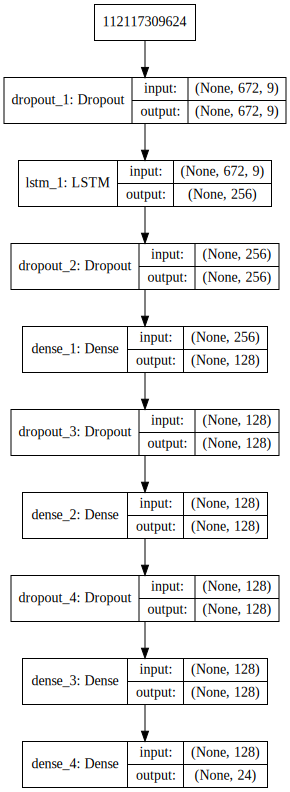

In [10]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [11]:
%%time

history = History()
nan_terminator = TerminateOnNaN()
early_stopping = EarlyStopping(patience=10, 
                               verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='loss', 
                              factor=0.5, 
                              patience=50, 
                              verbose=1, 
                              mode='auto', 
                              epsilon=0.0001, 
                              cooldown=0, 
                              min_lr=1e-8)

history = model.fit(train_X, train_y, epochs=250, batch_size=500, validation_split=0.1, verbose=2, shuffle=True,
                    callbacks=[history, nan_terminator, reduce_lr])

Train on 30 samples, validate on 4 samples
Epoch 1/250
 - 2s - loss: 0.8761 - val_loss: 0.5232
Epoch 2/250
 - 1s - loss: 0.7108 - val_loss: 0.3180
Epoch 3/250
 - 1s - loss: 0.5883 - val_loss: 0.2102
Epoch 4/250
 - 1s - loss: 0.5625 - val_loss: 0.2730
Epoch 5/250
 - 1s - loss: 0.5164 - val_loss: 0.2752
Epoch 6/250
 - 1s - loss: 0.5769 - val_loss: 0.2897
Epoch 7/250
 - 1s - loss: 0.5219 - val_loss: 0.2709
Epoch 8/250
 - 1s - loss: 0.4603 - val_loss: 0.2506
Epoch 9/250
 - 1s - loss: 0.4308 - val_loss: 0.2349
Epoch 10/250
 - 1s - loss: 0.4467 - val_loss: 0.2236
Epoch 11/250
 - 1s - loss: 0.4167 - val_loss: 0.2149
Epoch 12/250
 - 1s - loss: 0.4113 - val_loss: 0.1999
Epoch 13/250
 - 1s - loss: 0.3717 - val_loss: 0.1830
Epoch 14/250
 - 1s - loss: 0.3861 - val_loss: 0.1701
Epoch 15/250
 - 1s - loss: 0.3395 - val_loss: 0.1597
Epoch 16/250
 - 1s - loss: 0.3621 - val_loss: 0.1553
Epoch 17/250
 - 1s - loss: 0.3459 - val_loss: 0.1544
Epoch 18/250
 - 1s - loss: 0.3375 - val_loss: 0.1503
Epoch 19/250

Epoch 154/250
 - 1s - loss: 0.0805 - val_loss: 0.0673
Epoch 155/250
 - 1s - loss: 0.0752 - val_loss: 0.0679
Epoch 156/250
 - 1s - loss: 0.0777 - val_loss: 0.0685
Epoch 157/250
 - 1s - loss: 0.0741 - val_loss: 0.0687
Epoch 158/250
 - 1s - loss: 0.0778 - val_loss: 0.0691
Epoch 159/250
 - 1s - loss: 0.0791 - val_loss: 0.0691
Epoch 160/250
 - 1s - loss: 0.0778 - val_loss: 0.0692
Epoch 161/250
 - 1s - loss: 0.0797 - val_loss: 0.0690
Epoch 162/250
 - 1s - loss: 0.0787 - val_loss: 0.0689
Epoch 163/250
 - 1s - loss: 0.0788 - val_loss: 0.0688
Epoch 164/250
 - 1s - loss: 0.0758 - val_loss: 0.0682
Epoch 165/250
 - 1s - loss: 0.0767 - val_loss: 0.0674
Epoch 166/250
 - 1s - loss: 0.0787 - val_loss: 0.0667
Epoch 167/250
 - 1s - loss: 0.0775 - val_loss: 0.0659
Epoch 168/250
 - 1s - loss: 0.0766 - val_loss: 0.0656
Epoch 169/250
 - 1s - loss: 0.0753 - val_loss: 0.0655
Epoch 170/250
 - 1s - loss: 0.0732 - val_loss: 0.0658
Epoch 171/250
 - 1s - loss: 0.0776 - val_loss: 0.0660
Epoch 172/250
 - 1s - loss: 

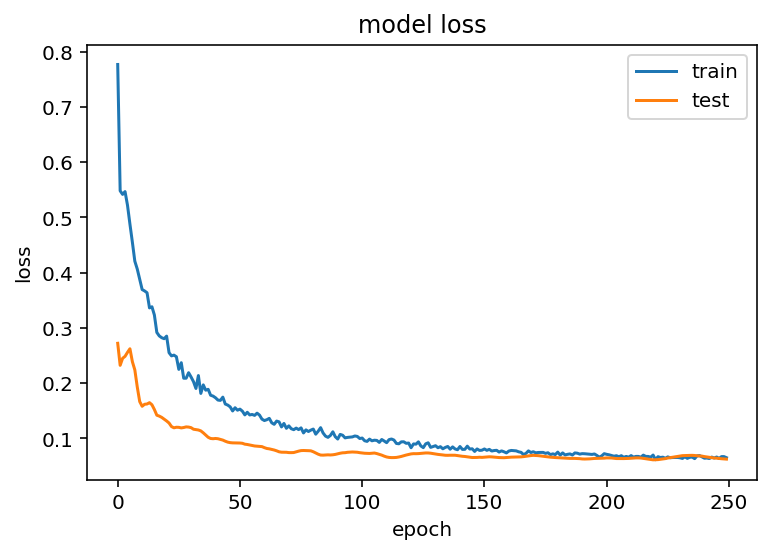

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [13]:
%%time 

test_X, test_y = create_tensors(df_test.drop('id', axis = 1), h_params['column_value'], h_params['n_in'], h_params['n_out'], h_params['step_foreward'])
prediction = model.predict(test_X)

CPU times: user 1.48 s, sys: 271 ms, total: 1.75 s
Wall time: 782 ms


In [15]:

yHat = scaler.inverse_transform(prediction).reshape(prediction.shape[0] * prediction.shape[1])
y = scaler.inverse_transform(test_y).reshape(test_y.shape[0] * test_y.shape[1])

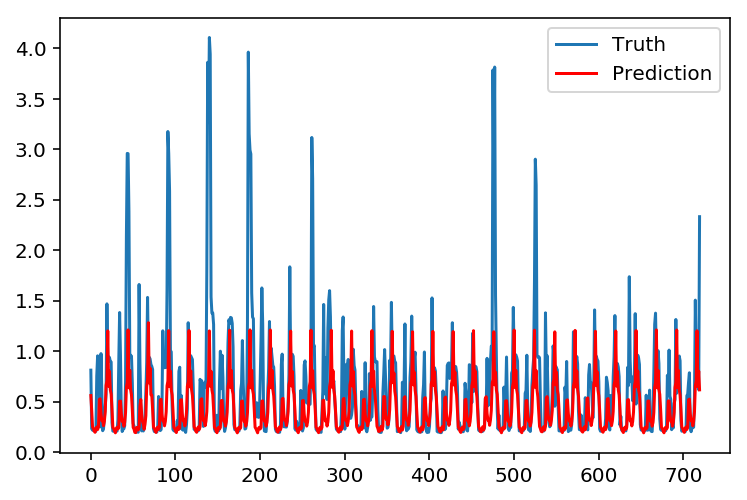

In [17]:
record = yHat[:-24]
plt.plot(y)
plt.plot(record, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.show()

In [18]:
print ('MAE', median_absolute_error(y, record))
print ('R2',  r2_score(y, record))

mape = np.mean(np.abs((record - y) / y )) * 100
smape = np.mean(np.abs((record - y) / (np.abs(y) + np.abs(record)) )) * 100
print("MAPE: %.2f SMAPE: %.2f" % (mape, smape))

MAE 0.15545186972618102
R2 0.16113643450163884
MAPE: 36.07 SMAPE: 20.42


In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 672, 9)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               272384    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

In [ ]:
# prediction = np.delete(prediction, -1)

CONFIDENCE BANDS

In [ ]:
def predict_with_uncertainty(model, test_X, n_iter=100):
    f = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])
    all_pred = np.zeros((n_iter,) + (1, 24,))
    for iter in range(n_iter):
        all_pred[iter] = f([test_X, 1])
    ts_std = all_pred.std(axis = 0)
    avg_pred = all_pred.mean(axis=0)
    return all_pred, avg_pred, ts_std

In [20]:
file = 'smart_meters_london_cleaned_same_start_with_weather_example.csv'
data_path = '/Users/dimitriskemos/Desktop/Data/'
params = {'column_sort': 'date_time'}

df = load_series(data_path, file, params)
df.index = df.index.tz_localize('UCT').tz_convert('Etc/GMT-1')

In [21]:
h_params = {'n_in': 24, 'n_out': 24, 'step_foreward': 24, 'column_value': 'energy'}
date_train =  datetime.strptime('2014-01-27 23:00:00', '%Y-%m-%d %H:%M:%S')
df_train = df[df.index <= date_train].drop('id', axis = 1)
df_test = df[df.index > date_train].drop('id', axis = 1)
df_train.head()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,energy
date,,,,,,,,,
2013-10-30 00:00:00+01:00,14.31,244,6.86,4.61,1017.98,4.55,3.29,0.86,0.457
2013-10-30 01:00:00+01:00,14.31,238,6.10,4.09,1018.38,3.86,2.95,0.87,0.414
2013-10-30 02:00:00+01:00,13.45,247,5.94,4.17,1018.89,3.54,3.14,0.88,0.408
2013-10-30 03:00:00+01:00,13.23,249,5.54,3.92,1019.25,3.13,3.02,0.89,0.352
2013-10-30 04:00:00+01:00,14.31,242,5.06,3.28,1019.57,2.78,2.74,0.88,0.250


In [22]:
df_train['weekday'] = df_train.index.weekday
df_train['hour'] = df_train.index.hour
df_test['weekday'] = df_test.index.weekday
df_test['hour'] = df_test.index.hour

In [23]:
from sklearn.preprocessing import StandardScaler

features = ['hour', 'weekday', 'visibility', 'windBearing', 'temperature', 'dewPoint', 
            'pressure', 'apparentTemperature', 'windSpeed', 'humidity']
scaler = StandardScaler()
for f in features:
    scaler_features = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(df_train[[f]])
    df_train[[f]] = scaler.transform(df_train[[f]])
    df_test[[f]] = scaler.transform(df_test[[f]])
    
scaler = MinMaxScaler(feature_range=(0, 1))
# train the scaler on the training data
scaler.fit(df_train[[h_params['column_value']]])
df_train[[h_params['column_value']]] = scaler.transform(df_train[[h_params['column_value']]])
df_test[[h_params['column_value']]] = scaler.transform(df_test[[h_params['column_value']]])

In [24]:
df_train.describe()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,energy,weekday,hour
count,2.160000e+03,2.160000e+03,2.160000e+03,2.160000e+03,2.160000e+03,2.160000e+03,2.160000e+03,2.160000e+03,2160.000000,2.160000e+03,2.160000e+03
mean,2.676871e-16,1.039549e-16,5.621018e-16,2.220446e-17,9.534554e-15,8.789266e-17,1.731318e-16,1.066200e-15,0.090101,5.972589e-16,6.167906e-19
std,1.000232e+00,1.000232e+00,1.000232e+00,1.000232e+00,1.000232e+00,1.000232e+00,1.000232e+00,1.000232e+00,0.118516,1.000232e+00,1.000232e+00
min,-3.561198e+00,-3.035492e+00,-3.123796e+00,-2.673902e+00,-2.464678e+00,-2.877091e+00,-1.738816e+00,-3.199748e+00,0.000000,-1.511204e+00,-1.661325e+00
25%,-3.464336e-01,-3.989671e-01,-6.824829e-01,-7.991757e-01,-8.081420e-01,-7.055842e-01,-7.185244e-01,-6.685851e-01,0.005903,-1.011174e+00,-8.306624e-01
50%,3.144068e-01,3.071426e-02,3.997403e-02,-2.841728e-02,3.297348e-02,-1.099589e-01,-1.635542e-01,2.518380e-01,0.052302,-1.111180e-02,0.000000e+00
75%,5.661555e-01,5.153948e-01,6.666405e-01,6.783918e-01,8.555412e-01,5.852831e-01,4.938721e-01,7.120495e-01,0.140024,9.889499e-01,8.306624e-01
max,1.679150e+00,1.900687e+00,2.731059e+00,2.872866e+00,1.900342e+00,2.626735e+00,4.429892e+00,1.977631e+00,1.000000,1.488981e+00,1.661325e+00


In [25]:
train_X, train_y = create_tensors(df_train, h_params['column_value'], h_params['n_in'], h_params['n_out'], h_params['step_foreward'])

In [26]:
%%time
model = keras_model(dropout_rate=0.2)
model.compile(loss='mae', optimizer=Adam())

history = History()
nan_terminator = TerminateOnNaN()
early_stopping = EarlyStopping(patience=10, 
                               verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='loss', 
                              factor=0.5, 
                              patience=50, 
                              verbose=1, 
                              mode='auto', 
                              epsilon=0.0001, 
                              cooldown=0, 
                              min_lr=1e-8)

history = model.fit(train_X, train_y, epochs=250, batch_size=500, validation_split=0.1, verbose=1, shuffle=True,
                    callbacks=[history, nan_terminator, reduce_lr])

Train on 80 samples, validate on 9 samples
Epoch 1/250
80/80 [==============================] - 1s 18ms/step - loss: 0.2187 - val_loss: 0.1239
Epoch 2/250
80/80 [==============================] - 0s 715us/step - loss: 0.1739 - val_loss: 0.0983
Epoch 3/250
80/80 [==============================] - 0s 796us/step - loss: 0.1600 - val_loss: 0.0844
Epoch 4/250
80/80 [==============================] - 0s 841us/step - loss: 0.1434 - val_loss: 0.0749
Epoch 5/250
80/80 [==============================] - 0s 754us/step - loss: 0.1344 - val_loss: 0.0703
Epoch 6/250
80/80 [==============================] - 0s 744us/step - loss: 0.1277 - val_loss: 0.0708
Epoch 7/250
80/80 [==============================] - 0s 750us/step - loss: 0.1214 - val_loss: 0.0710
Epoch 8/250
80/80 [==============================] - 0s 773us/step - loss: 0.1155 - val_loss: 0.0706
Epoch 9/250
80/80 [==============================] - 0s 757us/step - loss: 0.1150 - val_loss: 0.0709
Epoch 10/250
80/80 [=============================

Epoch 81/250
80/80 [==============================] - 0s 720us/step - loss: 0.0503 - val_loss: 0.0572
Epoch 82/250
80/80 [==============================] - 0s 717us/step - loss: 0.0504 - val_loss: 0.0574
Epoch 83/250
80/80 [==============================] - 0s 708us/step - loss: 0.0511 - val_loss: 0.0575
Epoch 84/250
80/80 [==============================] - 0s 747us/step - loss: 0.0512 - val_loss: 0.0574
Epoch 85/250
80/80 [==============================] - 0s 731us/step - loss: 0.0516 - val_loss: 0.0568
Epoch 86/250
80/80 [==============================] - 0s 701us/step - loss: 0.0500 - val_loss: 0.0563
Epoch 87/250
80/80 [==============================] - 0s 701us/step - loss: 0.0508 - val_loss: 0.0557
Epoch 88/250
80/80 [==============================] - 0s 708us/step - loss: 0.0502 - val_loss: 0.0553
Epoch 89/250
80/80 [==============================] - 0s 716us/step - loss: 0.0506 - val_loss: 0.0552
Epoch 90/250
80/80 [==============================] - 0s 702us/step - loss: 0.0512

Epoch 161/250
80/80 [==============================] - 0s 726us/step - loss: 0.0458 - val_loss: 0.0585
Epoch 162/250
80/80 [==============================] - 0s 729us/step - loss: 0.0457 - val_loss: 0.0582
Epoch 163/250
80/80 [==============================] - 0s 784us/step - loss: 0.0455 - val_loss: 0.0577
Epoch 164/250
80/80 [==============================] - 0s 758us/step - loss: 0.0463 - val_loss: 0.0575
Epoch 165/250
80/80 [==============================] - 0s 787us/step - loss: 0.0446 - val_loss: 0.0572
Epoch 166/250
80/80 [==============================] - 0s 721us/step - loss: 0.0453 - val_loss: 0.0571
Epoch 167/250
80/80 [==============================] - 0s 721us/step - loss: 0.0453 - val_loss: 0.0571
Epoch 168/250
80/80 [==============================] - 0s 792us/step - loss: 0.0445 - val_loss: 0.0572
Epoch 169/250
80/80 [==============================] - 0s 755us/step - loss: 0.0465 - val_loss: 0.0571
Epoch 170/250
80/80 [==============================] - 0s 770us/step - lo

Epoch 241/250
80/80 [==============================] - 0s 751us/step - loss: 0.0426 - val_loss: 0.0575
Epoch 242/250
80/80 [==============================] - 0s 705us/step - loss: 0.0418 - val_loss: 0.0577
Epoch 243/250
80/80 [==============================] - 0s 720us/step - loss: 0.0422 - val_loss: 0.0579
Epoch 244/250
80/80 [==============================] - 0s 719us/step - loss: 0.0411 - val_loss: 0.0582
Epoch 245/250
80/80 [==============================] - 0s 762us/step - loss: 0.0406 - val_loss: 0.0585
Epoch 246/250
80/80 [==============================] - 0s 742us/step - loss: 0.0413 - val_loss: 0.0586
Epoch 247/250
80/80 [==============================] - 0s 727us/step - loss: 0.0417 - val_loss: 0.0585
Epoch 248/250
80/80 [==============================] - 0s 739us/step - loss: 0.0399 - val_loss: 0.0581
Epoch 249/250
80/80 [==============================] - 0s 744us/step - loss: 0.0419 - val_loss: 0.0579
Epoch 250/250
80/80 [==============================] - 0s 786us/step - lo

In [35]:
test_X, test_y = create_tensors(df_test, h_params['column_value'], h_params['n_in'], h_params['n_out'], h_params['step_foreward'])
prediction = model.predict(test_X)

In [40]:
yHat = scaler.inverse_transform(prediction).reshape(prediction.shape[0] * prediction.shape[1])
y = scaler.inverse_transform(test_y).reshape(prediction.shape[0] * prediction.shape[1])
import numpy as np
np.savetxt("lstm.csv", yHat, delimiter=",", fmt='%s')

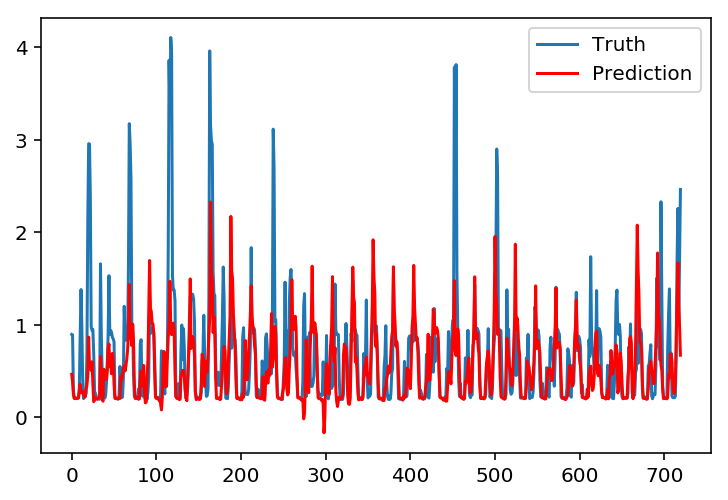

In [37]:
plt.plot(y)
plt.plot(yHat, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.show()

In [39]:
mape = np.mean(np.abs((yHat - y) / y )) * 100
smape = np.mean(np.abs((yHat - y) / (np.abs(y) + np.abs(yHat)) )) * 100
print ('MAE', median_absolute_error(y, yHat))
print("MAPE: %.2f SMAPE: %.2f" % (mape, smape))

MAE 0.14665813541412354
MAPE: 39.49 SMAPE: 19.21
